In [86]:
import pandas as pd

import json
import requests
import chardet

import geopandas as gpd

import matplotlib.pyplot as plt
import folium

In [87]:
# Load Germany's boundaries (from Natural Earth dataset)
germany = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = germany[germany.name == "Germany"]

/tmp/ipykernel_5730/2535236628.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  germany = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [88]:
# 📌Load CSV file with postal codes and coordinates
df1 = pd.read_csv("plz_geocoord.csv") # Ensure the correct file path
print(df1.head())


# 📌  Load additional data containing postal codes and other information
csv_path = "data.csv"  # Ensure the correct file path
with open(csv_path, "rb") as f:
    result = chardet.detect(f.read(5000))  # Читаем первые 5000 байт для анализа
    print(result)

df2 = pd.read_csv(csv_path, dtype={"PLZ": str}, sep=";", encoding=result["encoding"])
print(df2.head())

    PLZ        lat        lng
0  1067  51.057550  13.717065
1  1069  51.039135  13.737675
2  1097  51.065908  13.736152
3  1099  51.087188  13.802804
4  1108  51.144324  13.799706
{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}
  code\n                              PrUfungsstellename          Bundesland  \
0   5920  BBQ Bildung und Berufliche Qualifizierung gGmbh  Baden-WUrrtemberg   
1  21118                                    VHS Winnenden  Baden-WUrrtemberg   
2  10563                           Anglo-german Institute  Baden-WUrttemberg   
3   6060     Arbeitskreis fUr Aus- und Weiterbildung e.V.  Baden-WUrttemberg   
4  10826     Arbeitskreis fUr Aus- und Weiterbildung e.V.  Baden-WUrttemberg   

     PLZ        Ort          Strasse  
0  72070   TUbingen     Europaplatz   
1  71364  Winnenden         Markstr.  
2  70174  Stuttgart  Friedrichstra§e  
3  74072  Heilbronn            Allee  
4  76185  Karlsruhe  Griesbachstra§e  


In [89]:
# Checking data
print(df1.columns)  
print(df2.columns)

df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip() 

df1["PLZ"] = df1["PLZ"].astype(str)
df2["PLZ"] = df2["PLZ"].astype(str)

Index(['PLZ', 'lat', 'lng'], dtype='object')
Index(['code\n', 'PrUfungsstellename ', 'Bundesland', 'PLZ', 'Ort', 'Strasse'], dtype='object')


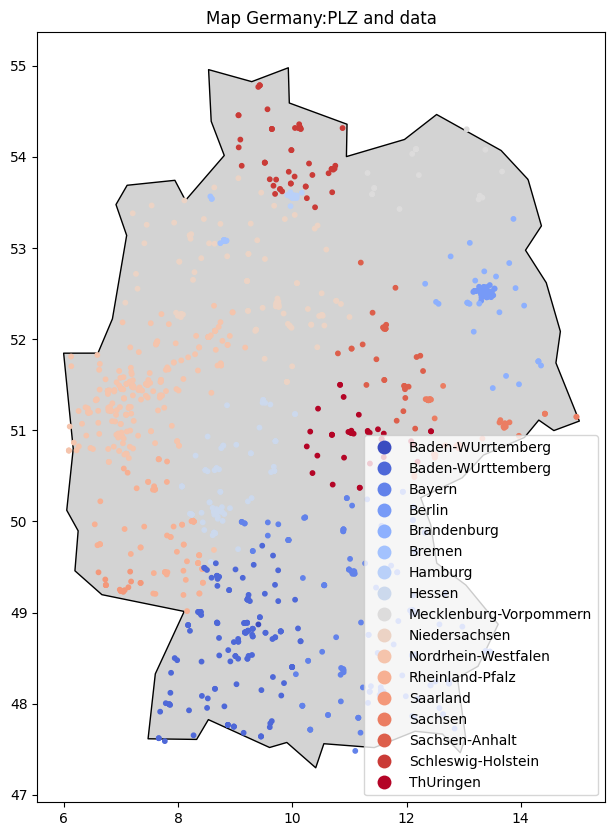

In [90]:
# Merge both datasets on the postal code column (PLZ)
df = df1.merge(df2, on="PLZ", how="left")  # left join

# Create a GeoDataFrame with coordinates
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lng, df.lat), crs="EPSG:4326")

# Vizualization with colour scale 
fig, ax = plt.subplots(figsize=(8, 10))
germany.plot(ax=ax, color='lightgray', edgecolor="black")

# Color of points depend on BundesLand
sc = gdf.plot(ax=ax, column="Bundesland", cmap="coolwarm", markersize=10, legend=True)

plt.title("Map Germany:PLZ and data")
plt.show()

In [91]:
# 🔹 Загружаем границы Bundesland (можно скачать GeoJSON: https://github.com/isellsoap/deutschlandGeoJSON)
geojson_url = "https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/3_regierungsbezirke/1_sehr_hoch.geo.json"
response = requests.get(geojson_url)


# Проверяем статус код и правильность JSON

if response.status_code == 200:
    try:
        geojson_data = response.json()  # Преобразуем в JSON
    except requests.exceptions.JSONDecodeError as e:
        print("Ошибка декодирования JSON:", e)
        print("Содержимое ответа:", response.text[:500])  # Выведем первые 500 символов
        geojson_data = None
else:
    print(f"Ошибка загрузки GeoJSON. Код ответа: {response.status_code}")
    geojson_data = None
bundesland_gdf = gpd.read_file(geojson_url)

# Initialize the Folium map centered on Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6, tiles="CartoDB positron")

# 🔹 Добавляем границы федеральных земель
folium.GeoJson(
    bundesland_gdf,
    name="Bundesländer",
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.1
    },
    tooltip=folium.GeoJsonTooltip(fields=["NAME_1"], aliases=["Bundesland: "])
).add_to(m)

# Add markers for each location
for _, row in df.iterrows():
    if pd.notna(row["lat"]) and pd.notna(row["lng"]) and pd.notna(row["PrUfungsstellename"]):
        popup_text = f"""
        <b>{row["PrUfungsstellename"]}</b><br>
        📍 Ort: {row["Ort"]}<br>
        🏠 Strasse: {row["Strasse"]}<br>
        🌍 Bundesland: {row["Bundesland"]}
        """
        folium.Marker(
            location=[row["lat"], row["lng"]],
            popup=folium.Popup(popup_text, max_width=300),#row["PrUfungsstellename"],  # Всплывающее окно с названием
            tooltip=row["PrUfungsstellename"] , # Текст при наведении 
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(m)

# 🔹 Добавляем слой для включения/выключения Bundesland
folium.LayerControl().add_to(m)
# Save the interactive map to an HTML file
m.save("map.html")

print("✅ Map saved in map.html. Open it in browser!")

✅ Map saved in map.html. Open it in browser!
